In [1]:
# importing libraries
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn import svm
from keras.utils.vis_utils import plot_model
from sklearn.model_selection  import train_test_split
#from sklearn.cross_validation import train_test_split


# For custom metrics
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 


import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt



import seaborn as sns
from IPython.display import Image

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from nltk.tokenize import word_tokenize
import string
import gensim
import os
import re

np.random.seed(0)

import plotly as py
import plotly.graph_objs as go
import plotly



# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Double check with Python 3


In [2]:
!gdown --id 1fG5qvMDy1ztRzUKWMqQP7v0AJvov0Pvt
!unzip SOD22_dataset.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fG5qvMDy1ztRzUKWMqQP7v0AJvov0Pvt
To: /content/SOD22_dataset.zip
100% 2.99M/2.99M [00:00<00:00, 131MB/s]
Archive:  SOD22_dataset.zip
  inflating: SOD22_dataset.csv       


In [3]:
full_df = pd.read_csv('SOD22_dataset.csv')

In [4]:
full_df['tweet'][4646]

'not ignoring the actual overtones about suffering in a capitalist world and feeling dehumanized by the inability to feel totally fulfilled by art/creation Which in and of itself has cut me to my core. i will simply interpret  the crumbs for my ship to avoid Depression❤️'

In [5]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))


def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = ' '.join(word for word in text.split() if word not in stops) # remove stopwors from text
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
full_df['tweet'] = full_df['tweet'].apply(clean_text)

In [7]:
df_non = full_df[full_df['label']=='non-depressed']
df_mild = full_df[full_df['label']=='mild']
df_mod = full_df[full_df['label']=='moderate']
df_sev = full_df[full_df['label']=='severe']

In [8]:
df_non.drop(df_non.columns[[2, 3, 4, 6, 7]], axis = 1, inplace = True)
df_mild.drop(df_mild.columns[[2, 3, 4, 6, 7]], axis = 1, inplace = True)
df_mod.drop(df_mod.columns[[2, 3, 4, 6, 7]], axis = 1, inplace = True)
df_sev.drop(df_sev.columns[[2, 3, 4, 6, 7]], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
df_non_train = df_non.sample(frac=0.8, random_state=200)
df_non_train.reset_index()
df_non_test = df_non[~df_non.isin(df_non_train)].dropna()
df_non_test.reset_index()

,index,id,tweet,target
0,4,8.600000e+17,show ghastly! air washed-out desolation think ...,0.0
1,7,9.840000e+17,spirits lifted low spirited learnt lean whenev...,0.0
2,9,1.070000e+18,help figure truth behind depression hit harder...,0.0
3,31,1.310000e+18,prof: “emotional stress anxiety depression ove...,0.0
4,32,1.310000e+18,next part story talks scattered focus anxiety ...,0.0
...,...,...,...,...
6475,40155,1.450000e+18,idk i’m gonna watch midnight idol tonight i’m ...,0.0
6476,40161,1.450000e+18,getting real tired waking clogged sinuses dry ...,0.0
6477,40165,1.450000e+18,"always chance anything ""shot"" drop tired bit??...",0.0
6478,40178,1.450000e+18,i’m tired think brain melting,0.0


In [10]:
df_mild_train = df_mild.sample(frac=0.8, random_state=200)
df_mild_train.reset_index()
df_mild_test = df_mild[~df_mild.isin(df_mild_train)].dropna()
df_mild_test.reset_index()

,index,id,tweet,target
0,8,1.010000e+18,kids say 12yrs they're remembering downtrodden...,1.0
1,55,1.370000e+18,tbh find whole “yr worth dependent yr producti...,1.0
2,56,1.370000e+18,high levels exhaustion mess head big time like...,1.0
3,152,1.420000e+18,trying figure trying self destruct i'm followi...,1.0
4,211,1.420000e+18,staring directly image knocking teeth emotions...,1.0
...,...,...,...,...
1043,39780,1.450000e+18,5am irrational fear since wife grows lunch box...,1.0
1044,39851,1.450000e+18,yeah ends years tired hopelessly helplessly br...,1.0
1045,39915,1.450000e+18,maybe start drinking coffee bc im literally al...,1.0
1046,39990,1.450000e+18,boutta kin traveller bc im tired everyone's shit,1.0


In [11]:
df_mod_train = df_mod.sample(frac=0.8, random_state=200)
df_mod_train.reset_index()
df_mod_test = df_mod[~df_mod.isin(df_mod_train)].dropna()
df_mod_test.reset_index()

,index,id,tweet,target
0,6,9.570000e+17,stress &amp anxiety withdrawn people love drea...,2.0
1,97,1.400000e+18,depressed bitch tweet incoming - - - - - - heh...,2.0
2,130,1.410000e+18,completely understand wanting kill oneself kiw...,2.0
3,137,1.410000e+18,oh it’s super dumb someone spent lot time depr...,2.0
4,139,1.410000e+18,completely self aware mentally unstable worst ...,2.0
...,...,...,...,...
357,36855,1.450000e+18,fighting life everyday life lmao i’m tired gra...,2.0
358,36977,1.450000e+18,hope left we'll get improvement lifetime 90% s...,2.0
359,37271,1.450000e+18,straight wanting cry! i’m tired tired man,2.0
360,38673,1.450000e+18,know i’m learning go beat try getting mad shit...,2.0


In [12]:
df_sev_train = df_sev.sample(frac=0.8, random_state=200)
df_sev_train.reset_index()
df_sev_test = df_sev[~df_sev.isin(df_sev_train)].dropna()
df_sev_test.reset_index()

,index,id,tweet,target
0,50,1.360000e+18,rlly take 225mg effexor every day still feel d...,3.0
1,67,1.380000e+18,upsetting people home gets mad u unproductive ...,3.0
2,90,1.400000e+18,blocked unblocked people force unfollow things...,3.0
3,129,1.410000e+18,everyday feel like i’m going lose mind bc tort...,3.0
4,193,1.420000e+18,depression un-aliving isolation rotting coimg ...,3.0
...,...,...,...,...
143,32268,1.450000e+18,path self destruction,3.0
144,32323,1.450000e+18,finally long 2 year battle depression thought ...,3.0
145,32401,1.450000e+18,feel god always think depression attempting su...,3.0
146,35855,1.450000e+18,tired hun enough want live amongst scum find s...,3.0


In [13]:
train_df = pd.concat([df_non_train,df_mild_train,df_mod_train,df_sev_train], ignore_index=True)
test_df = pd.concat([df_non_test,df_mild_test,df_mod_test,df_sev_test], ignore_index=True)

In [14]:
train_df.sample(frac=1)
test_df.sample(frac=1)

,id,tweet,target
309,1.450000e+18,we're expecting deaths upcoming weeks i'm abso...,0.0
3029,1.450000e+18,coach coan warming coan pyne bother getting fr...,0.0
3239,1.450000e+18,droug ford created pot aggravation hate separa...,0.0
4630,1.450000e+18,lol everyone keeps saying im good mood work iv...,0.0
5253,1.450000e+18,yea really weird told decided try guilt trip w...,0.0
...,...,...,...
1871,1.450000e+18,you’re depressed unmotivated? today? go outsid...,0.0
2839,1.450000e+18,bleh sick sucks i'm tired exhausted i've sleep...,0.0
3660,1.450000e+18,went shopping morning fall winter clothes i’m ...,0.0
5138,1.450000e+18,oh god beautiful,0.0


In [35]:
#Convert text to vectors using keras preprocessing library tools

X_train = train_df["tweet"].values
X_test  = test_df["tweet"].values

y_train = train_df[["target"]].values
y_test  = test_df[["target"]].values

In [36]:
from keras.utils.np_utils import to_categorical   

y_train_categorical_labels = to_categorical(y_train, num_classes=4)
y_test_categorical_labels = to_categorical(y_test, num_classes=4)

In [17]:
test_ck = pd.DataFrame(X_train)
test_ck.columns = ["Response"]

length_of_the_messages = test_ck["Response"].str.split("\\s+")


print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.str.len().idxmax())

Max number of words =  50
Index =  4950


In [34]:
num_words = 20000 #Max. words to use per comment
max_features = 60000 #Max. number of unique words in embeddinbg vector
max_len = 64 #Max. number of words per toxic comment to be use
embedding_dims = 64 #embedding vector output dimension 
num_epochs = 10 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.1
batch_size2 = 64 #(before 32)The **batch size** is the number of training examples in one forward/backward pass.
                  # In general, larger batch sizes result in faster progress in training, but don't always converge as quickly. 
                  #Smaller batch sizes train slower, but can converge faster. And the higher the batch size, the more memory space you’ll need.


In [37]:
#Tokenization
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = sequence.pad_sequences(X_train, max_len, padding='post')
X_test  = sequence.pad_sequences(X_test,  max_len, padding='post')

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (32153, 64)
X_test shape:  (8038, 64)


In [38]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train_categorical_labels, train_size =0.9, random_state=233)
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

In [21]:
LSTM_model = Sequential([
    Embedding(input_dim =num_words, input_length=max_len, output_dim=embedding_dims, trainable=False),
    SpatialDropout1D(0.3),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    LSTM(64, return_sequences=True),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.3),
    GlobalMaxPool1D(),
    Dense(32, activation = 'relu'),
    Dropout(0.3),
    Dense(4, activation = 'sigmoid')
])

LSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [22]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 64)            1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 64, 64)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64, 64)            33024     
                                                                 
 batch_normalization (BatchN  (None, 64, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64, 64)            0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0

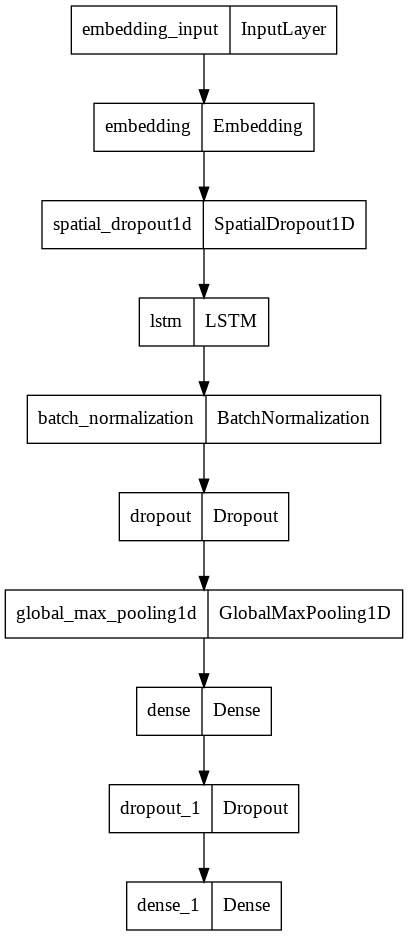

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(LSTM_model, to_file='LSTM_model.png')

In [24]:
LSTM_model_fit = LSTM_model.fit(X_tra, y_tra, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/10
453/453 [==============================] - 13s 12ms/step - loss: 0.6555 - accuracy: 0.8042 - val_loss: 0.6501 - val_accuracy: 0.8025
Epoch 2/10
453/453 [==============================] - 5s 12ms/step - loss: 0.6060 - accuracy: 0.8061 - val_loss: 0.5960 - val_accuracy: 0.8025
Epoch 3/10
453/453 [==============================] - 5s 12ms/step - loss: 0.5934 - accuracy: 0.8063 - val_loss: 0.6098 - val_accuracy: 0.8025
Epoch 4/10
453/453 [==============================] - 6s 13ms/step - loss: 0.5896 - accuracy: 0.8065 - val_loss: 0.5953 - val_accuracy: 0.8029
Epoch 5/10
453/453 [==============================] - 5s 12ms/step - loss: 0.5796 - accuracy: 0.8075 - val_loss: 0.5928 - val_accuracy: 0.8025
Epoch 6/10
453/453 [==============================] - 5s 12ms/step - loss: 0.5745 - accuracy: 0.8070 - val_loss: 0.6268 - val_accuracy: 0.7985
Epoch 7/10
453/453 [==============================] - 4s 9ms/step - loss: 0.5711 - accuracy: 0.8063 - val_loss: 0.6964 - val_accuracy: 0.7646

In [25]:
pred_lstm = LSTM_model.predict(X_test)

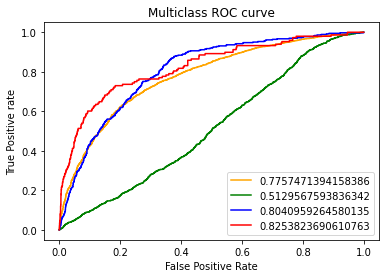

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc = {}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_lstm[:,i], pos_label=i)
    roc[i]   = roc_auc_score(y_test_categorical_labels[:,i], pred_lstm[:,i], multi_class='ovr')

    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='-',color='orange', label= roc[0])
plt.plot(fpr[1], tpr[1], linestyle='-',color='green', label=roc[1])
plt.plot(fpr[2], tpr[2], linestyle='-',color='blue', label= roc[2])
plt.plot(fpr[3], tpr[3], linestyle='-',color='red', label= roc[3])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [39]:
Bi_LSTM_model = Sequential([
    Embedding(input_dim =num_words, input_length=max_len, output_dim=embedding_dims, trainable=False),
    SpatialDropout1D(0.3),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.3)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.3),
    GlobalMaxPool1D(),
    Dense(32, activation = 'relu'),
    Dropout(0.3),
    Dense(4, activation = 'sigmoid')
])

Bi_LSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

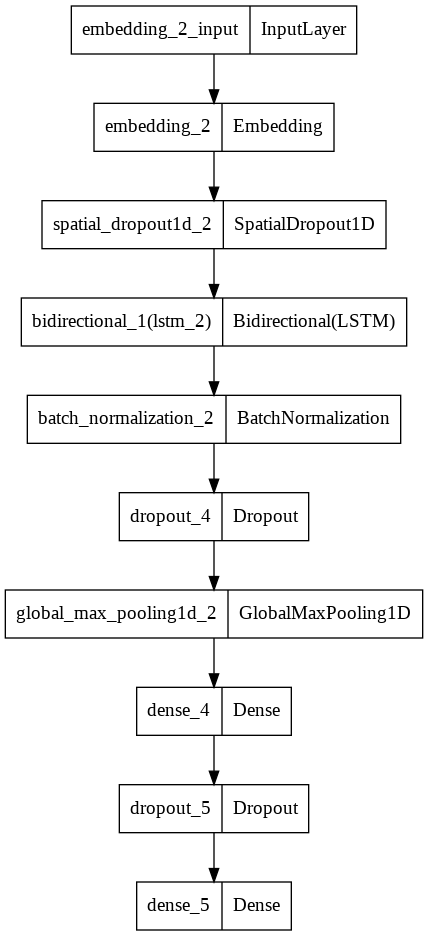

In [40]:
from keras.utils.vis_utils import plot_model
plot_model(Bi_LSTM_model, to_file='Bi_LSTM_model.png')

In [41]:
Bi_LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 64, 64)            1280000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 64, 64)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 64, 64)           24832     
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64, 64)            0         
                                                      

In [42]:
Bi_LSTM_model_fit = Bi_LSTM_model.fit(X_tra, y_tra, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/10
453/453 [==============================] - 177s 383ms/step - loss: 0.6642 - accuracy: 0.8048 - val_loss: 0.6379 - val_accuracy: 0.8025
Epoch 2/10
453/453 [==============================] - 171s 378ms/step - loss: 0.6138 - accuracy: 0.8065 - val_loss: 0.6032 - val_accuracy: 0.8025
Epoch 3/10
453/453 [==============================] - 172s 380ms/step - loss: 0.6068 - accuracy: 0.8065 - val_loss: 0.6052 - val_accuracy: 0.8025
Epoch 4/10
453/453 [==============================] - 172s 379ms/step - loss: 0.6008 - accuracy: 0.8065 - val_loss: 0.5961 - val_accuracy: 0.8025
Epoch 5/10
453/453 [==============================] - 172s 380ms/step - loss: 0.5964 - accuracy: 0.8065 - val_loss: 0.5891 - val_accuracy: 0.8025
Epoch 6/10
453/453 [==============================] - 172s 380ms/step - loss: 0.5903 - accuracy: 0.8065 - val_loss: 0.5841 - val_accuracy: 0.8025
Epoch 7/10
453/453 [==============================] - 172s 381ms/step - loss: 0.5872 - accuracy: 0.8067 - val_loss: 0.6055 -

In [43]:
pred_bi_lstm = Bi_LSTM_model.predict(X_test)

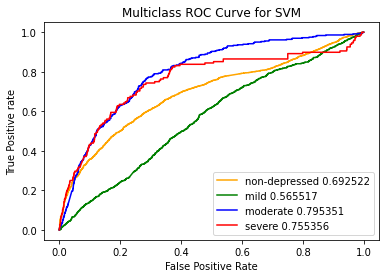

In [44]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc = {}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_bi_lstm[:,i], pos_label=i)
    roc[i]   = roc_auc_score(y_test_categorical_labels[:,i], pred_bi_lstm[:,i], multi_class='ovr')

    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='-',color='orange', label= 'non-depressed '+ str(round(roc[0],6)))
plt.plot(fpr[1], tpr[1], linestyle='-',color='green', label= 'mild '+ str(round(roc[1],6)))
plt.plot(fpr[2], tpr[2], linestyle='-',color='blue', label= 'moderate '+ str(round(roc[2],6)))
plt.plot(fpr[3], tpr[3], linestyle='-',color='red', label= 'severe '+ str(round(roc[3],6)))


plt.title('Multiclass ROC Curve for SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')





In [45]:
from sklearn.metrics import roc_curve, auc

def calc_roc_auc(all_labels, all_logits, name=None):
    attributes = ['non-depressed','mild','moderate','severe']
    
    

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(0,len(attributes)):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_logits[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[0], tpr[0], color='blue', label='%s %g' % (attributes[0], roc_auc[0]))
    plt.plot(fpr[1], tpr[1], color='orange', label='%s %g' % (attributes[1], roc_auc[1]))
    plt.plot(fpr[2], tpr[2], color='green', label='%s %g' % (attributes[2], roc_auc[2]))
    plt.plot(fpr[3], tpr[3], color='red', label='%s %g' % (attributes[3], roc_auc[3]))

    plt.xticks(np.arange(0, 1.2, step=0.2))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')
    plt.grid(False)
    
    

    plt.savefig(f"---roc_auc_curve_Bi_LSTM---.pdf")
    plt.clf()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_logits.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print(f'ROC-AUC Score: {roc_auc["micro"]}')

calc_roc_auc(y_test_categorical_labels,pred_bi_lstm)

ROC-AUC Score: 0.918274473413928


<Figure size 432x288 with 0 Axes>